# Data Collection

## Stock Price Data Collection

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_columns', None)

In [273]:
class get_stock_data:
    
    @classmethod
    def download_daily_stock_price(cls, stock_list, start_date, end_date):
        df_stock_combined = pd.DataFrame()
        for stock in sorted(stock_list):
            df = yf.download(stock, start=start_date, end=end_date)
            df['stock'] = stock
            df_stock_combined = pd.concat([df_stock_combined, df])
        df_stock_combined.reset_index(inplace=True)
        df_stock_combined.columns = [col.lower() for col in df_stock_combined.columns]
        df_stock_combined.rename(columns={'date': 'trading_date'}, inplace=True)
        return df_stock_combined

In [274]:
df_stock_combined = get_stock_data.download_daily_stock_price(['TSLA', 'AMZN', 'NVDA', 'AAPL', 'FB'], '2020-01-01', '2022-04-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [275]:
df_stock_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840 entries, 0 to 2839
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   trading_date  2840 non-null   datetime64[ns]
 1   open          2840 non-null   float64       
 2   high          2840 non-null   float64       
 3   low           2840 non-null   float64       
 4   close         2840 non-null   float64       
 5   adj close     2840 non-null   float64       
 6   volume        2840 non-null   int64         
 7   stock         2840 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 177.6+ KB


# Data Collation

## Combine Scapped Data

In [25]:
import os
from pathlib import Path
from ast import literal_eval
from datetime import datetime

In [236]:
class combine_files:
    
    @classmethod
    def get_all_files_list(cls, root_folder_dir):
        
        file_dir_list = []
        for root, dirs, files in os.walk(root_folder_dir):
            for file in files:
                #append the file name to the list
                file_dir_list.append(os.path.join(root,file))
        return file_dir_list
        
        # for path, subdirs, files in os.walk(root_folder_dir):
        #     for name in files:
        #         file_dir_list = list(os.path.join(path, name))
        #         print(file_dir_list)
    
    @classmethod
    def get_sentiment_score(cls, string_entities):
        try:
            sentiment_label = literal_eval(string_entities)['sentiment']['basic']
            if sentiment_label == 'Bullish':
                return 1
            elif sentiment_label == 'Bearish':
                return 0
            else:
                return np.nan
        except:
            return np.nan
        
    @classmethod    
    def get_likes_count(cls, string_likes):
        try:
            count_like = literal_eval(string_likes)['total']
            return count_like
        except:
        # need to return 0 instead of NA to prevent Nan values
            return 0

    @classmethod
    def get_reshares_count(cls, string_reshares):
        try:
            count_reshare = literal_eval(string_reshares)['reshared_count']
            return count_reshare
        except:
        # need to return 0 instead of NA to prevent Nan values
            return 0
        
    @classmethod
    def read_file(cls, file_dir):
        df = pd.read_csv(file_dir, usecols=['body', 'created_at', 'likes', 'reshares', 'entities'])
        stock_label = Path(file_dir).stem.split('_')[0]
        df['stock'] = stock_label
        df['count_like'] = df['likes'].apply(lambda x: cls.get_likes_count(x))
        df['count_reshare'] = df['reshares'].apply(lambda x: cls.get_reshares_count(x))
        df['sentiment_score'] = df['entities'].apply(lambda x: cls.get_sentiment_score(x))
        df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
        df.rename(columns={'created_at': 'created_at_utc'}, inplace=True)
        df.drop(columns=['entities', 'likes', 'reshares'], inplace=True)
        return df
        
    @classmethod
    def combine_files(cls, root_folder_dir):
        file_dir_list = cls.get_all_files_list(root_folder_dir)
        df_combined = pd.DataFrame()
        for file in file_dir_list:
            df = cls.read_file(file)
            df_combined = pd.concat([df_combined, df], ignore_index=True)
        df_combined.sort_values(by=['stock', 'created_at_utc'], inplace=True)
        df_combined.reset_index(drop=True, inplace=True)
        return df_combined
            
    @classmethod
    def filter_by_datetime_range(cls, df_combined, date_time=datetime.strptime('2020-01-01 00:00:00-05:00', '%Y-%m-%d %H:%M:%S%z')):
        df_combined = df_combined[df_combined['created_at_utc'] >= date_time]
        df_combined.reset_index(drop=True, inplace=True)
        return df_combined
    
    @classmethod
    def transform_and_output(cls, root_folder_dir, output_folder_dir):
        df_combined = cls.combine_files(root_folder_dir)
        df_combined = cls.filter_by_datetime_range(df_combined)
        output_file_dir = os.path.join(output_folder_dir, 'stocktwits_combined.csv')
        df_combined.to_csv(output_file_dir, index=False)
        print(f"combined file is output to {output_file_dir}")
        return df_combined
        

In [237]:
test_folder_dir = r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Raw\test'
test_output_dir = r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\test'

In [238]:
root_folder_dir = r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Raw\stocktwits'
output_folder_dir = r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined'

In [240]:
df_twits_combined = combine_files.transform_and_output(root_folder_dir, output_folder_dir)

combined file is output to C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\stocktwits_combined.csv


In [ ]:
# df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
# # filter messages from 2020-01-01 00:00 US Eastern Time onwards, UTC-5 timezone
# df = df[df['created_at'] >= datetime.strptime('2020-01-01 00:00:00-05:00', '%Y-%m-%d %H:%M:%S%z')]

In [254]:
df_twits_combined.head(10)

,created_at_utc,stock,count_like,count_reshare,sentiment_score,body_prepared,body_processed
0,2020-01-01 05:06:58+00:00,AAPL,2.0,NaN,1.0,$AAPL good things happening 2020 run trump and everything’s gonna run up get it while you can follow the trend,good things happening 2020 run trump and everything’s gonna run up get it while you can follow the trend
1,2020-01-01 05:08:28+00:00,AAPL,3.0,NaN,1.0,$AAPL Happy New Year amazing winning AAPL Bulls! You’re making life fun and exciting!,Happy New Year amazing winning AAPL Bulls! You’re making life fun and exciting!
2,2020-01-01 05:14:51+00:00,AAPL,21.0,NaN,1.0,Happy New Year :) $AAPL $TSLA $AMZN $SPY $BTC.X,Happy New Year :) .X
3,2020-01-01 05:19:59+00:00,AAPL,1.0,NaN,NaN,@Taxes_R2_Damn_High my dad ended this year by selling half his $aapl and $MSFT Two decades in almost exactly. I think no one is being careful. These parabolic moves can be dangerous. I know everyone is cheerful now!,my dad ended this year by selling half his and Two decades in almost exactly. I think no one is being careful. These parabolic moves can be dangerous. I know everyone is cheerful now!
4,2020-01-01 05:37:42+00:00,AAPL,1.0,NaN,1.0,"$AAPL And to those using the tired and old delapidated PE ratio argument, I'll just leave you with this, oh, ours? Just 24.7 PE, at end of 2019 (with a massively more room to grow ).... Compare Apples' PE to other megacaps=, quote from article with a false negative title to begin with = &quot;Compared with the other megacap tech stocks, Apple's P/E ratio still ranks among the lowest. Amazon is finishing the year with a P/E of 81.8, Facebook's is 32.8, Microsoft's is 29.7, and Google-parent Alphabet's is 28.7.&quot; !!!HAPPY NEW YEAR EVERYBODY!!! After its strongest year in a decade, Apple stock is historically expensive on a price-to-earnings basis -","And to those using the tired and old delapidated PE ratio argument, I'll just leave you with this, oh, ours? Just 24.7 PE, at end of 2019 (with a massively more room to grow ).... Compare Apples' PE to other megacaps=, quote from article with a false negative title to begin with = &quot;Compared with the other megacap tech stocks, Apple's P/E ratio still ranks among the lowest. Amazon is finishing the year with a P/E of 81.8, Facebook's is 32.8, Microsoft's is 29.7, and Google-parent Alphabet's is 28.7.&quot; !!!HAPPY NEW YEAR EVERYBODY!!! After its strongest year in a decade, Apple stock is historically expensive on a price-to-earnings basis -"
5,2020-01-01 05:41:36+00:00,AAPL,1.0,NaN,1.0,$AAPL **&quot;With massively more room to grow&quot; not &quot; with (a) massively room to grow&quot; silly stocktwits won't let me erase and repost with right grammar. Oh well..you get the picture. Happy New Year! 😎,**&quot;With massively more room to grow&quot; not &quot; with (a) massively room to grow&quot; silly stocktwits won't let me erase and repost with right grammar. Oh well..you get the picture. Happy New Year! smiling_face_with_sunglasses
6,2020-01-01 06:00:25+00:00,AAPL,6.0,NaN,1.0,$AAPL gonna rip on Thursday for the new year,gonna rip on Thursday for the new year
7,2020-01-01 06:04:36+00:00,AAPL,31.0,NaN,1.0,$AAPL $MSFT $AMZN $PTI bulls and bears.. Happy New Years!! May all of us little fish make some 💰 this upcoming year.,bulls and bears.. Happy New Years!! May all of us little fish make some money_bag this upcoming year.
8,2020-01-01 06:12:03+00:00,AAPL,1.0,NaN,NaN,"Bullish investment portfolio: Apple($AAPL), International Bancshares($IBOC),… #correlations #stocks #stockratings","Bullish investment portfolio: Apple(), International Bancshares(),…"
9,2020-01-01 06:48:59+00:00,AAPL,6.0,NaN,1.0,$AAPL $TSLA been to 6 dealerships in last few weeks. Non stop deliveries to the point they canceled my service rQ (tesla). Been to 4 Apple stores. Packed packed packed. Entire middle class upgrade cycle next 24months. $SPY $DJIA,been to 6 dealerships in last few weeks. Non stop deliveries to the point they canceled my service rQ (tesla). Been 

In [167]:
df_twits_combined.iloc[30:40]

,body,created_at_utc,stock,count_like,count_reshare,sentiment_score
30,$AAPL as in for all of 2020 as well,2020-01-01 13:28:57+00:00,AAPL,NaN,NaN,NaN
31,"$AAPL - This will try to reach $300 in the next few days! Bullish for the whole year! $SPY , $QQQ . \nThis is the reason the market will rise another 20% this year!",2020-01-01 13:49:44+00:00,AAPL,2.0,NaN,1.0
32,@sonicmerlin $AAPL - looks like it&#39;s going to pop to $300!,2020-01-01 13:52:05+00:00,AAPL,NaN,NaN,1.0
33,$AAPL,2020-01-01 13:53:41+00:00,AAPL,NaN,NaN,NaN
34,$AAPL 👌🏼,2020-01-01 13:59:19+00:00,AAPL,1.0,NaN,NaN
35,$ANET $AAPL $SHOP $TSLA $AMZN its all about technique focus on the technique,2020-01-01 14:11:21+00:00,AAPL,7.0,NaN,NaN
36,Take to time to $STUDY my Youtube channel Today Link is here https://www.youtube.com/c/PowerTargetTrades as I lead my group into the new year with back to back to back wins in the best stocks right into the new year. $AAPL being the best and $TSLA our 2nd great weapon for making the best gains with skill based on a the big picture of the market and my times tested system rules. This Link here https://youtu.be/d8jgDB_O2wY Explains how to become a member inside my free unique being managed by a leader group as I have been massively correct the big picture on real market direction with many great plans since 2016 all documented on my Youtube Channel. If your serious for success start the new year right by doing some serious $study,2020-01-01 14:17:04+00:00,AAPL,1.0,NaN,NaN
37,"$AAPL After its strongest year in a decade, Apple stock is historically expensive on a price-to-earnings basis - https://www.cnbc.com/2019/12/31/apple-pe-ratio-is-at-historic-high-following-an-explosive-year.html",2020-01-01 14:18:51+00:00,AAPL,NaN,NaN,NaN
38,Confident Investor indicator analysis for 1/1/2020. Interesting results from $LULU $AAPL $SINA $NXST #invest https://t.co/zmKHM7G8Ha,2020-01-01 14:21:52+00:00,AAPL,NaN,NaN,NaN
39,$AAPL . $300 next week!,2020-01-01 14:23:08+00:00,AAPL,4.0,NaN,1.0


# Data Transformation 

## Stock Price Label Generation

In [280]:
class stock_price_label_generation:
    
    @classmethod
    def labeller(cls, delta):
    # 1 is price increase, 0 is price decrease
        if delta >= 0:
            return 1
        elif delta < 0:
            return 0
        else:
            return np.nan
        
    @classmethod
    def generate_pre_day_volumn(cls, df_stock_combined):
        df_stock_combined_processed = pd.DataFrame()
        for stock in df_stock_combined['stock'].unique():
            df_stock = df_stock_combined[df_stock_combined['stock']==stock]
            df_stock['pre_day_volume'] = df_stock['volume'].shift(1)
            df_stock_combined_processed = pd.concat([df_stock_combined_processed, df_stock], ignore_index=True)
        return df_stock_combined_processed
    
    @classmethod
    def generate_same_day_adj_close_price_change(cls, df_stock_combined):
        df_stock_combined['price_change_same_day'] = np.where(df_stock_combined['adj close'] >= df_stock_combined['open'], 1, 0)
        return df_stock_combined
    
    @classmethod
    def generate_pre_day_adj_close_price_change(cls, df_stock_combined):
        df_stock_combined_processed = pd.DataFrame()
        for stock in df_stock_combined['stock'].unique():
            df_stock = df_stock_combined[df_stock_combined['stock']==stock]
            df_stock['price_diff_pre_day'] = df_stock['adj close'] - df_stock['adj close'].shift(1)
            df_stock_combined_processed = pd.concat([df_stock_combined_processed, df_stock], ignore_index=True)
        # label the price change, 1 as increase and 0 as decrease
        df_stock_combined_processed['price_change_pre_day'] = df_stock_combined_processed['price_diff_pre_day'].apply(lambda x: cls.labeller(x))
        df_stock_combined_processed.drop(columns=['price_diff_pre_day'], inplace=True)
        return df_stock_combined_processed
    
    @classmethod
    def generate_trading_close_datetime(cls, df):
        trading_close_time = datetime.strptime('16:00:00', '%H:%M:%S').time()
        df['next_close_datetime'] = df['trading_date'].apply(lambda x: datetime.combine(x, trading_close_time))
        return df
    
    @classmethod
    def normalize_by_z_score_by_group(cls, df, key='stock', col='pre_day_volume'):
        zscore = lambda x: (x - x.mean()) / x.std()
        df[f'{col}_zscore'] = df.groupby(key)[col].transform(zscore)
        return df
    
    @classmethod
    def transform(cls, df_stock_combined):
        df_stock_combined = cls.generate_pre_day_volumn(df_stock_combined)
        df_stock_combined = cls.generate_same_day_adj_close_price_change(df_stock_combined)
        df_stock_combined = cls.generate_pre_day_adj_close_price_change(df_stock_combined)
        df_stock_combined = cls.generate_trading_close_datetime(df_stock_combined)
        df_stock_combined = cls.normalize_by_z_score_by_group(df_stock_combined)
        df_stock_combined.drop(columns=['high', 'low', 'close', 'volume', 'pre_day_volume'], inplace=True)
        return df_stock_combined

In [247]:
def normalize_by_z_score_by_group(df, key='stock', col='volume'):
    zscore = lambda x: (x - x.mean()) / x.std()
    df[f'{col}_z_norm'] = df.groupby(key)[col].transform(zscore)
    return df

In [282]:
df_stock_combined_labelled = stock_price_label_generation.transform(df_stock_combined)

C:\Users\frank\AppData\Local\Temp\ipykernel_23436\1421083164.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['pre_day_volume'] = df_stock['volume'].shift(1)
C:\Users\frank\AppData\Local\Temp\ipykernel_23436\1421083164.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['pre_day_volume'] = df_stock['volume'].shift(1)
C:\Users\frank\AppData\Local\Temp\ipykernel_23436\1421083164.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [283]:
df_stock_combined_labelled.head()

,trading_date,open,adj close,stock,price_change_same_day,price_change_pre_day,next_close_datetime,pre_day_volume_zscore
0,2019-12-31,72.482498,72.245941,AAPL,0,NaN,2019-12-31 16:00:00,NaN
1,2020-01-02,74.059998,73.894333,AAPL,0,1.0,2020-01-02 16:00:00,-0.332439
2,2020-01-03,74.287498,73.175926,AAPL,0,0.0,2020-01-03 16:00:00,0.239195
3,2020-01-06,73.447502,73.759010,AAPL,1,1.0,2020-01-06 16:00:00,0.417939
4,2020-01-07,74.959999,73.412109,AAPL,0,0.0,2020-01-07 16:00:00,-0.042596


In [100]:
df_stock_combined_labelled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840 entries, 0 to 2839
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trading_date           2840 non-null   datetime64[ns]
 1   open                   2840 non-null   float64       
 2   adj close              2840 non-null   float64       
 3   stock                  2840 non-null   object        
 4   pre_day_volume         2835 non-null   float64       
 5   price_change_same_day  2840 non-null   int32         
 6   price_change_pre_day   2835 non-null   float64       
 7   next_close_datetime    2840 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int32(1), object(1)
memory usage: 166.5+ KB


## StockTwits Text Preparation

In [40]:
# backup procedure to read the output file in case that the following process stops
output_file = r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\stocktwits_combined.csv'
df_twits_combined = pd.read_csv(output_file)
df_twits_combined['created_at_utc'] = pd.to_datetime(df_twits_combined['created_at_utc'], utc=True)

In [42]:
df_twits_combined.shape

(4165805, 6)

In [37]:
# define preparation procedure for feature engineering
import re
class text_preparation:
    
    @classmethod
    def remove_url(cls, string):
        string = re.sub(r'https?://\S+', "", string)
        string = re.sub(r'www.\S+', "", string)
        return string
    
    @classmethod
    def remove_special_chars(cls, string):
        string = string.replace('\n', ' ').replace('&#39;', "'").replace('&quot;', '"')
        return string
    
    @classmethod
    def transform(cls, df):
        df['body_prepared'] = df['body']\
        .apply(lambda x: cls.remove_url(x))\
        .apply(lambda x: cls.remove_special_chars(x))
        df.drop(columns='body', inplace=True)
        return df

In [304]:
df_twits_combined = text_preparation.transform(df_twits_combined)

In [ ]:
# define text processing procedure
# may not be needed as the pre-processing will be defined at the sentiment model section
import emoji
class text_processing:
    
    @classmethod
    def convert_symbols(cls, string):
        string = re.sub(r'(\@)(\S+)', r'mention_\2', string)
        string = re.sub(r'(\#)(\S+)', r'hashtag_\2', string)
        string = re.sub(r'(\$)([A-Za-z]+)', r'cashtag_\2', string)
        return string
    
    # this method is not used in this processing because emoji needs to be converted after feature generation, as the convertion will affect the character length
    @classmethod
    def convert_emoji(cls, string):
        return emoji.demojize(string, delimiters=("", " "))
    
    @classmethod
    def transform(cls, df):
        df['body_processed'] = df['body_prepared']\
        .apply(lambda x: cls.convert_symbols(x))
        # emoji needs to be converted after feature generation, as the convertion will affect the character length
        return df

In [306]:
df_twits_combined = text_processing.transform(df_twits_combined)

In [309]:
df_twits_combined.head(10)

,created_at_utc,stock,count_like,count_reshare,sentiment_score,body_prepared,body_processed
0,2020-01-01 05:06:58+00:00,AAPL,2.0,NaN,1.0,$AAPL good things happening 2020 run trump and everything’s gonna run up get it while you can follow the trend,good things happening 2020 run trump and everything’s gonna run up get it while you can follow the trend
1,2020-01-01 05:08:28+00:00,AAPL,3.0,NaN,1.0,$AAPL Happy New Year amazing winning AAPL Bulls! You’re making life fun and exciting!,Happy New Year amazing winning AAPL Bulls! You’re making life fun and exciting!
2,2020-01-01 05:14:51+00:00,AAPL,21.0,NaN,1.0,Happy New Year :) $AAPL $TSLA $AMZN $SPY $BTC.X,Happy New Year :) .X
3,2020-01-01 05:19:59+00:00,AAPL,1.0,NaN,NaN,@Taxes_R2_Damn_High my dad ended this year by selling half his $aapl and $MSFT Two decades in almost exactly. I think no one is being careful. These parabolic moves can be dangerous. I know everyone is cheerful now!,my dad ended this year by selling half his and Two decades in almost exactly. I think no one is being careful. These parabolic moves can be dangerous. I know everyone is cheerful now!
4,2020-01-01 05:37:42+00:00,AAPL,1.0,NaN,1.0,"$AAPL And to those using the tired and old delapidated PE ratio argument, I'll just leave you with this, oh, ours? Just 24.7 PE, at end of 2019 (with a massively more room to grow ).... Compare Apples' PE to other megacaps=, quote from article with a false negative title to begin with = ""Compared with the other megacap tech stocks, Apple's P/E ratio still ranks among the lowest. Amazon is finishing the year with a P/E of 81.8, Facebook's is 32.8, Microsoft's is 29.7, and Google-parent Alphabet's is 28.7."" !!!HAPPY NEW YEAR EVERYBODY!!! After its strongest year in a decade, Apple stock is historically expensive on a price-to-earnings basis -","And to those using the tired and old delapidated PE ratio argument, I'll just leave you with this, oh, ours? Just 24.7 PE, at end of 2019 (with a massively more room to grow ).... Compare Apples' PE to other megacaps=, quote from article with a false negative title to begin with = ""Compared with the other megacap tech stocks, Apple's P/E ratio still ranks among the lowest. Amazon is finishing the year with a P/E of 81.8, Facebook's is 32.8, Microsoft's is 29.7, and Google-parent Alphabet's is 28.7."" !!!HAPPY NEW YEAR EVERYBODY!!! After its strongest year in a decade, Apple stock is historically expensive on a price-to-earnings basis -"
5,2020-01-01 05:41:36+00:00,AAPL,1.0,NaN,1.0,"$AAPL **""With massively more room to grow"" not "" with (a) massively room to grow"" silly stocktwits won't let me erase and repost with right grammar. Oh well..you get the picture. Happy New Year! 😎","**""With massively more room to grow"" not "" with (a) massively room to grow"" silly stocktwits won't let me erase and repost with right grammar. Oh well..you get the picture. Happy New Year! 😎"
6,2020-01-01 06:00:25+00:00,AAPL,6.0,NaN,1.0,$AAPL gonna rip on Thursday for the new year,gonna rip on Thursday for the new year
7,2020-01-01 06:04:36+00:00,AAPL,31.0,NaN,1.0,$AAPL $MSFT $AMZN $PTI bulls and bears.. Happy New Years!! May all of us little fish make some 💰 this upcoming year.,bulls and bears.. Happy New Years!! May all of us little fish make some 💰 this upcoming year.
8,2020-01-01 06:12:03+00:00,AAPL,1.0,NaN,NaN,"Bullish investment portfolio: Apple($AAPL), International Bancshares($IBOC),… #correlations #stocks #stockratings","Bullish investment portfolio: Apple(), International Bancshares(),…"
9,2020-01-01 06:48:59+00:00,AAPL,6.0,NaN,1.0,$AAPL $TSLA been to 6 dealerships in last few weeks. Non stop deliveries to the point they canceled my service rQ (tesla). Been to 4 Apple stores. Packed packed packed. Entire middle class upgrade cycle next 24months. $SPY $DJIA,been to 6 dealerships in last few weeks. Non stop deliveries to the point they canceled my service rQ (tesla). Been to 4 Apple stores. Packed packed packed. Entire middle class upgrade cycle next

## Feature Engineering

### Generate Text Related Features

In [35]:
output_file = r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\stocktwits_combined.csv'
df_twits_combined = pd.read_csv(output_file)
df_twits_combined['created_at_utc'] = pd.to_datetime(df_twits_combined['created_at_utc'], utc=True)

In [39]:
import nltk
class text_feature_engieering:
    
    @classmethod
    def count_alpha(cls, string):
        return sum(map(str.isalpha, string))
    
    @classmethod
    def count_digit(cls, string):
        return sum(map(str.isdigit, string))
    
    @classmethod
    def count_emoji(cls, string): 
        # return len(nlp(string)._.emoji) spacy is slow so replace with emoji count functions
        return emoji.emoji_count(string)
        
    @classmethod
    def count_all_char(cls, string):
        return len([c for c in string if c != ' ' ])
    
    @classmethod
    def count_token(cls, string):
        # return len([token.text for token in nlp(string) if token.text not in punc_list])
        # string.split() is not fully correct as ☝🏿☝☝ will be count as single token, but it's significant faster than using spacy
        return len(string.split())
    
    @classmethod
    def count_sent(cls, string):
        return len(nltk.sent_tokenize(string))
        
    @classmethod
    def count_mention(cls, string):
        return len(re.findall(r'(\@)(\S+)', string))
        
    @classmethod
    def count_hashtag(cls, string):
        return len(re.findall(r'(\#)(\S+)', string))
        
    @classmethod
    def count_cashtag(cls, string):
        return len(re.findall(r"\$[A-Za-z]+", string))
    
    @classmethod
    def transform(cls, df):
        # below features are based on the original text
        df['count_mention'] = df['body_prepared'].apply(lambda x: cls.count_mention(x))
        df['count_hashtag'] = df['body_prepared'].apply(lambda x: cls.count_hashtag(x))
        df['count_cashtag'] = df['body_prepared'].apply(lambda x: cls.count_cashtag(x))
        df['count_emoji'] = df['body_prepared'].apply(lambda x: cls.count_emoji(x))
        # below features are based on processed text
        df['count_alpha'] = df['body_processed'].apply(lambda x: cls.count_alpha(x))
        df['count_digit'] = df['body_processed'].apply(lambda x: cls.count_digit(x))
        df['count_all_char'] = df['body_processed'].apply(lambda x: cls.count_all_char(x))
        df['count_token'] = df['body_processed'].apply(lambda x: cls.count_token(x))
        df['count_sent'] = df['body_processed'].apply(lambda x: cls.count_sent(x))
        # finally, convert emoji to text
        df['body_processed'] = df['body_processed'].apply(lambda x: text_processing.convert_emoji(x))
        return df

In [312]:
df_twits_combined_with_feature = text_feature_engieering.transform(df_twits_combined)

In [314]:
df_twits_combined_with_feature.to_csv(r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\df_twits_combined_with_feature.csv', index=False)

### Generate Time Related Features 

In [4]:
output_file = r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\df_twits_combined_with_feature.csv'
df_twits_combined_with_feature = pd.read_csv(output_file)
df_twits_combined_with_feature['created_at_utc'] = pd.to_datetime(df_twits_combined_with_feature['created_at_utc'], utc=True)

In [34]:
df_twits_combined_with_feature.shape

(4165805, 25)

In [11]:
import time
import pytz
# define US eastern standard time with day time saving considered 
est = pytz.timezone('US/Eastern')

class localized_time_features:
    
    @classmethod
    def convet_local_time(cls, df):
        # convert to us eastern local time, considering day time saving
        df['created_at_local'] = df['created_at_utc'].apply(lambda x: x.astimezone(est))
        return df
       
    @classmethod
    def generate_local_time_features(cls, df):
        df['created_month_local'] = df['created_at_local'].apply(lambda x: x.month)
        df['created_day_local'] = df['created_at_local'].apply(lambda x: x.day)
        # weekday starts from Monday as 1
        df['created_weekday_local'] = df['created_at_local'].apply(lambda x: x.isoweekday())
        df['created_hour_local'] = df['created_at_local'].apply(lambda x: x.time().hour)
        return df
    
    @classmethod
    def transform(cls, df):
        df = cls.convet_local_time(df)
        df = cls.generate_local_time_features(df)
        return df

In [12]:
df_twits_combined_with_feature_with_time = localized_time_features.transform(df_twits_combined_with_feature)

In [46]:
df_twits_combined_with_feature_with_time.shape

(4165805, 25)

In [27]:
from datetime import timedelta

class trading_time_features:
    
    @classmethod
    def get_trading_day_list(cls, df_stock):
        trading_day_list = list(df_stock['date'].apply(lambda x: x.date()).unique())
        trading_day_list.sort()
        return trading_day_list
    
    @classmethod
    def check_within_trading_time(cls, date, time, trading_day_list):
        # simplified with the trading time. Some days actually have a earlier closing time but not considered here
        start_trading_time = datetime.strptime('09:30:00', '%H:%M:%S').time()
        end_trading_time = datetime.strptime('16:00:00', '%H:%M:%S').time()
        if (date in trading_day_list) and (start_trading_time <= time <= end_trading_time):
            return True
        else:
            return False
        
    @classmethod
    # this method is to check the date of the next trading close date. Same day if it's before 4pm on a trading day. After that, it will be the next trading day
    def check_next_trading_close_date(cls, date, time, trading_day_list):
        end_trading_time = datetime.strptime('16:00:00', '%H:%M:%S').time()
        if time > end_trading_time:
            date = date + timedelta(days=1)
        next_close_date = next((d for d in trading_day_list if d >= date), np.nan)
        next_close_datetime = datetime.combine(next_close_date, end_trading_time)
        return next_close_datetime
    
    @classmethod
    def transform(cls, df_twits, df_stock):
        trading_day_list = cls.get_trading_day_list(df_stock)
        df_twits['within_trading_time'] = df_twits['created_at_local'].apply(lambda x: cls.check_within_trading_time(x.date(), x.time(), trading_day_list))
        df_twits['next_close_datetime'] = df_twits['created_at_local'].apply(lambda x: cls.check_next_trading_close_date(x.date(), x.time(), trading_day_list))
        df_twits['hours_till_close'] = df_twits.apply(lambda x: (x['next_close_datetime'] - x['created_at_local'].replace(tzinfo=None)).total_seconds()//3600, axis=1)
        df_twits['hours_till_close'] = df_twits['hours_till_close'].astype(int)
        return df_twits

In [28]:
df_twits_combined_with_feature_with_time = trading_time_features.transform(df_twits_combined_with_feature_with_time, df_stock_combined_labelled)

In [32]:
df_twits_combined_with_feature_with_time.shape

(4165805, 25)

In [79]:
df_twits_combined_with_feature_with_time.to_csv(r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\df_twits_combined_with_feature_with_time.csv', index=False)

## Combine Target Variable

In [142]:
# join with stock labels
df_twits_combined_with_feature_with_time_with_stock = df_twits_combined_with_feature_with_time.merge(df_stock_combined_labelled, how='left', on=['stock', 'next_close_datetime'])

In [149]:
df_twits_combined_with_feature_with_time_with_stock.columns

Index(['created_at_utc', 'stock', 'count_like', 'count_reshare',
       'sentiment_score', 'body_prepared', 'body_processed', 'count_mention',
       'count_hashtag', 'count_cashtag', 'count_emoji', 'count_alpha',
       'count_digit', 'count_all_char', 'count_token', 'count_sent',
       'created_month_local', 'created_day_local', 'created_weekday_local',
       'created_hour_local', 'within_trading_time', 'hours_till_close',
       'trading_date', 'pre_day_volume', 'price_change_same_day',
       'price_change_pre_day', 'created_date_local'],
      dtype='object')

In [144]:
# add created_date_local, which is useful for grouping purposes
df_twits_combined_with_feature_with_time_with_stock['created_date_local'] = df_twits_combined_with_feature_with_time_with_stock['created_at_local'].apply(lambda x: x.date())

In [145]:
# drop features that will not be used for prediction later 
df_twits_combined_with_feature_with_time_with_stock.drop(columns=['created_at_local', 'next_close_datetime', 'minutes_till_close', 'open', 'adj close'], inplace=True)

In [146]:
df_twits_combined_with_feature_with_time_with_stock = df_twits_combined_with_feature_with_time_with_stock.convert_dtypes()

In [147]:
df_twits_combined_with_feature_with_time_with_stock.to_csv(r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\df_twits_combined_with_feature_with_time_with_stock.csv', index=False)

In [153]:
df_twits_combined_with_feature_with_time_with_stock.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4165805 entries, 0 to 4165804
Data columns (total 27 columns):
 #   Column                 Dtype              
---  ------                 -----              
 0   created_at_utc         datetime64[ns, UTC]
 1   stock                  string             
 2   count_like             Int64              
 3   count_reshare          Int64              
 4   sentiment_score        Int64              
 5   body_prepared          string             
 6   body_processed         string             
 7   count_mention          Int64              
 8   count_hashtag          Int64              
 9   count_cashtag          Int64              
 10  count_emoji            Int64              
 11  count_alpha            Int64              
 12  count_digit            Int64              
 13  count_all_char         Int64              
 14  count_token            Int64              
 15  count_sent             Int64              
 16  created_month_loca

####  reprocess text as the entity was all removed, resulting some text rows with NA value.

In [318]:
df_twits_combined_with_feature_with_time_with_stock = pd.read_csv(r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\df_twits_combined_with_feature_with_time_with_stock.csv')

In [192]:
df_twits_combined_with_feature_with_time_with_stock[df_twits_combined_with_feature_with_time_with_stock['body_processed'].isna()].head(5)

,created_at_utc,stock,count_like,count_reshare,sentiment_score,body_prepared,body_processed,count_mention,count_hashtag,count_cashtag,count_emoji,count_alpha,count_digit,count_all_char,count_token,count_sent,created_month_local,created_day_local,created_weekday_local,created_hour_local,within_trading_time,hours_till_close,trading_date,pre_day_volume,price_change_same_day,price_change_pre_day,created_date_local
33,2020-01-01 13:53:41+00:00,AAPL,<NA>,<NA>,<NA>,$AAPL,<NA>,0,0,1,0,0,0,0,0,0,1,1,3,8,False,31,2020-01-02,100805600,0,1,2020-01-01
49,2020-01-01 14:54:35+00:00,AAPL,2,<NA>,<NA>,$AAPL,<NA>,0,0,1,0,0,0,0,0,0,1,1,3,9,False,30,2020-01-02,100805600,0,1,2020-01-01
137,2020-01-01 21:41:58+00:00,AAPL,1,<NA>,<NA>,$AAPL,<NA>,0,0,1,0,0,0,0,0,0,1,1,3,16,False,23,2020-01-02,100805600,0,1,2020-01-01
231,2020-01-02 03:09:26+00:00,AAPL,2,<NA>,<NA>,$AAPL,<NA>,0,0,1,0,0,0,0,0,0,1,1,3,22,False,17,2020-01-02,100805600,0,1,2020-01-01
371,2020-01-02 13:15:32+00:00,AAPL,<NA>,<NA>,<NA>,$AAPL,<NA>,0,0,1,0,0,0,0,0,0,1,2,4,8,False,7,2020-01-02,100805600,0,1,2020-01-02


In [181]:
# backup procedure to read the output file in case that the following process stops
df_twits_combined_reprocess = pd.read_csv(r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\df_twits_combined_with_feature.csv', usecols=['body_prepared'])

In [183]:
df_twits_combined_reprocess = text_processing.transform(df_twits_combined_reprocess)
df_twits_combined_reprocess['body_processed'] = df_twits_combined_reprocess['body_processed'].apply(lambda x: text_processing.convert_emoji(x))

In [316]:
df_twits_combined_reprocess.drop(columns='body_prepared', inplace=True)

In [317]:
df_twits_combined_reprocess.head(5)

,body_processed
0,cashtag_AAPL good things happening 2020 run trump and everything’s gonna run up get it while you can follow the trend
1,cashtag_AAPL Happy New Year amazing winning AAPL Bulls! You’re making life fun and exciting!
2,Happy New Year :) cashtag_AAPL cashtag_TSLA cashtag_AMZN cashtag_SPY cashtag_BTC.X
3,mention_Taxes_R2_Damn_High my dad ended this year by selling half his cashtag_aapl and cashtag_MSFT Two decades in almost exactly. I think no one is being careful. These parabolic moves can be dangerous. I know everyone is cheerful now!
4,"cashtag_AAPL And to those using the tired and old delapidated PE ratio argument, I'll just leave you with this, oh, ours? Just 24.7 PE, at end of 2019 (with a massively more room to grow ).... Compare Apples' PE to other megacaps=, quote from article with a false negative title to begin with = ""Compared with the other megacap tech stocks, Apple's P/E ratio still ranks among the lowest. Amazon is finishing the year with a P/E of 81.8, Facebook's is 32.8, Microsoft's is 29.7, and Google-parent Alphabet's is 28.7."" !!!HAPPY NEW YEAR EVERYBODY!!! After its strongest year in a decade, Apple stock is historically expensive on a price-to-earnings basis -"


#### replace the column with new processed text

In [319]:
df_twits_combined_with_feature_with_time_with_stock['body_processed'] = df_twits_combined_reprocess['body_processed']

#### replace NA values

In [320]:
df_twits_combined_with_feature_with_time_with_stock['count_like'] = df_twits_combined_with_feature_with_time_with_stock['count_like'].fillna(0)
df_twits_combined_with_feature_with_time_with_stock['count_reshare'] = df_twits_combined_with_feature_with_time_with_stock['count_reshare'].fillna(0)

In [321]:
df_twits_combined_with_feature_with_time_with_stock = df_twits_combined_with_feature_with_time_with_stock.convert_dtypes()

In [322]:
df_twits_combined_with_feature_with_time_with_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4165805 entries, 0 to 4165804
Data columns (total 27 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   created_at_utc         string 
 1   stock                  string 
 2   count_like             Int64  
 3   count_reshare          Int64  
 4   sentiment_score        Int64  
 5   body_prepared          string 
 6   body_processed         string 
 7   count_mention          Int64  
 8   count_hashtag          Int64  
 9   count_cashtag          Int64  
 10  count_emoji            Int64  
 11  count_alpha            Int64  
 12  count_digit            Int64  
 13  count_all_char         Int64  
 14  count_token            Int64  
 15  count_sent             Int64  
 16  created_month_local    Int64  
 17  created_day_local      Int64  
 18  created_weekday_local  Int64  
 19  created_hour_local     Int64  
 20  within_trading_time    boolean
 21  hours_till_close       Int64  
 22  trading_date      

In [323]:
df_twits_combined_with_feature_with_time_with_stock['trading_date'] = pd.to_datetime(df_twits_combined_with_feature_with_time_with_stock['trading_date'])

In [325]:
df_twits_combined_with_feature_with_time_with_stock.head(2)

,created_at_utc,stock,count_like,count_reshare,sentiment_score,body_prepared,body_processed,count_mention,count_hashtag,count_cashtag,count_emoji,count_alpha,count_digit,count_all_char,count_token,count_sent,created_month_local,created_day_local,created_weekday_local,created_hour_local,within_trading_time,hours_till_close,trading_date,pre_day_volume,price_change_same_day,price_change_pre_day,created_date_local
0,2020-01-01 05:06:58+00:00,AAPL,2,0,1,$AAPL good things happening 2020 run trump and everything’s gonna run up get it while you can follow the trend,cashtag_AAPL good things happening 2020 run trump and everything’s gonna run up get it while you can follow the trend,0,0,1,0,81,4,86,19,1,1,1,3,0,False,39,2020-01-02,100805600,0,1,2020-01-01
1,2020-01-01 05:08:28+00:00,AAPL,3,0,1,$AAPL Happy New Year amazing winning AAPL Bulls! You’re making life fun and exciting!,cashtag_AAPL Happy New Year amazing winning AAPL Bulls! You’re making life fun and exciting!,0,0,1,0,64,0,67,13,2,1,1,3,0,False,39,2020-01-02,100805600,0,1,2020-01-01


#### convert pre_day_volume to z-score

In [326]:
df_twits_combined_with_feature_with_time_with_stock_new = df_twits_combined_with_feature_with_time_with_stock.merge(df_stock_combined_labelled[['stock', 'trading_date', 'pre_day_volume_zscore']], on=['stock', 'trading_date'], how='left').drop(columns='pre_day_volume')

In [327]:
df_twits_combined_with_feature_with_time_with_stock_new.shape

(4165805, 27)

#### Save file

In [329]:
#  save file
df_twits_combined_with_feature_with_time_with_stock_new.to_csv(r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\df_twits_combined_with_feature_with_time_with_stock_new.csv', index=False)

### Combine with predicted sentiment score

In [3]:
df_twits_combined_with_feature_with_time_with_stock_new = pd.read_csv(r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\df_twits_combined_with_feature_with_time_with_stock_new.csv')

In [5]:
df_combined_predicted = pd.read_csv(r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\df_combined_predicted.csv', usecols=['sentiment_score', 'sentiment_score_predicted'])

In [10]:
df_combined_predicted.shape

(4165805, 2)

In [9]:
df_combined_predicted.isna().sum()

sentiment_score              2014973
sentiment_score_predicted    2150832
dtype: int64

In [15]:
df_twits_combined_with_feature_with_time_with_stock_new['sentiment_score_predicted'] = df_combined_predicted['sentiment_score_predicted']

In [20]:
df_twits_combined_with_feature_with_time_with_stock_new['sentiment_score_combined'] = df_combined_predicted['sentiment_score'].fillna(df_combined_predicted['sentiment_score_predicted'])
df_twits_combined_with_feature_with_time_with_stock_new['sentiment_score_combined'] = df_twits_combined_with_feature_with_time_with_stock_new['sentiment_score_combined'].astype(int)

In [67]:
df_twits_combined_with_feature_with_time_with_stock_new = df_twits_combined_with_feature_with_time_with_stock_new.astype({'sentiment_score': 'Int64', 'sentiment_score_predicted': 'Int64'})

In [26]:
#  save file
df_twits_combined_with_feature_with_time_with_stock_new.to_csv(r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\df_twits_combined_with_feature_with_time_with_stock_with_prediction.csv', index=False)

## EDA for features

In [122]:
import plotly.express as px
def eda_by_group(df, grouping_list=['hours_till_close', 'stock']):
    df_group = df.groupby(grouping_list)['body_processed'].count().reset_index()
    fig = px.bar(df_group, x='hours_till_close', y='body_processed', color='stock', title='Count of StockTwits per Hour till Stock Closing Time')
    fig.add_vline(x=6, annotation_text='trading', annotation_position='top left')
    fig.add_vline(x=16, annotation_text='midnight', annotation_position='top left')
    fig.add_vline(x=23, annotation_text='next days are none-trading', annotation_position='top right')
    fig.show()

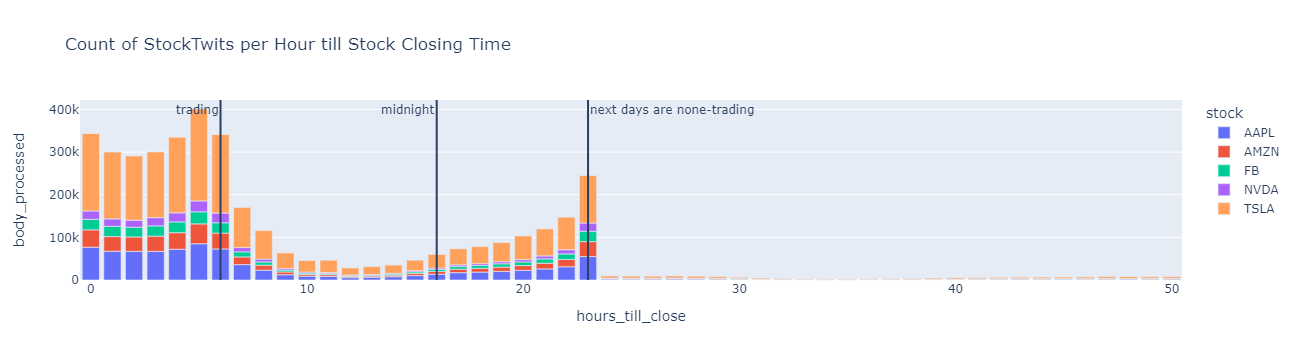

In [123]:
eda_by_group(df_twits_combined_with_feature_with_time_with_stock_new)

In [124]:
def eda_by_group_2(df, grouping_list=['hours_till_close', 'stock']):
    # for within_trading_time in [True, False]:
    # df_group = df[df['within_trading_time']==within_trading_time].groupby(grouping_list)['count_all_char'].mean().reset_index()
    df_group = df.groupby(grouping_list)['count_all_char'].mean().reset_index()
    fig = px.line(df_group, x='hours_till_close', y='count_all_char', color='stock', title='Average of Charaster Length per Hour till Stock Closing Time')
    fig.add_vline(x=6, annotation_text='trading', annotation_position='top left')
    fig.add_vline(x=16, annotation_text='midnight', annotation_position='top left')
    fig.add_vline(x=23, annotation_text='next days are none-trading', annotation_position='top right')
    fig.show()

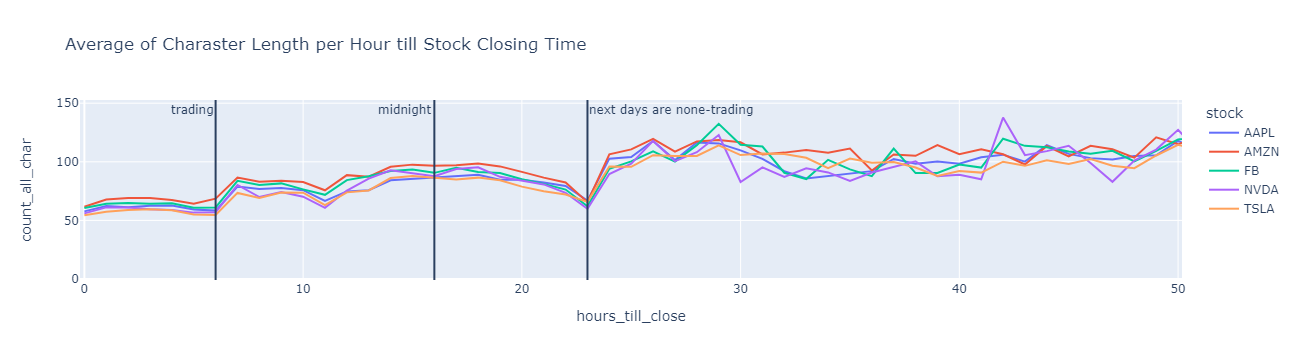

In [125]:
eda_by_group_2(df_twits_combined_with_feature_with_time_with_stock_new)

In [84]:
def eda_by_group_3(df, grouping_list=['price_change_pre_day', 'stock']):
    # for within_trading_time in [True, False]:
    # df_group = df[df['within_trading_time']==within_trading_time].groupby(grouping_list)['count_all_char'].mean().reset_index()
    df_group = df.groupby(grouping_list)['sentiment_score'].mean().reset_index()
    fig = px.bar(df_group,
                 x='sentiment_score',
                 y='price_change_pre_day',
                 facet_col='stock',
                 # color='price_change_pre_day',
                 title='Average of Sentiment Score per Target Group',
                 orientation='h')
    fig.update_yaxes(type='category')
    fig.show()

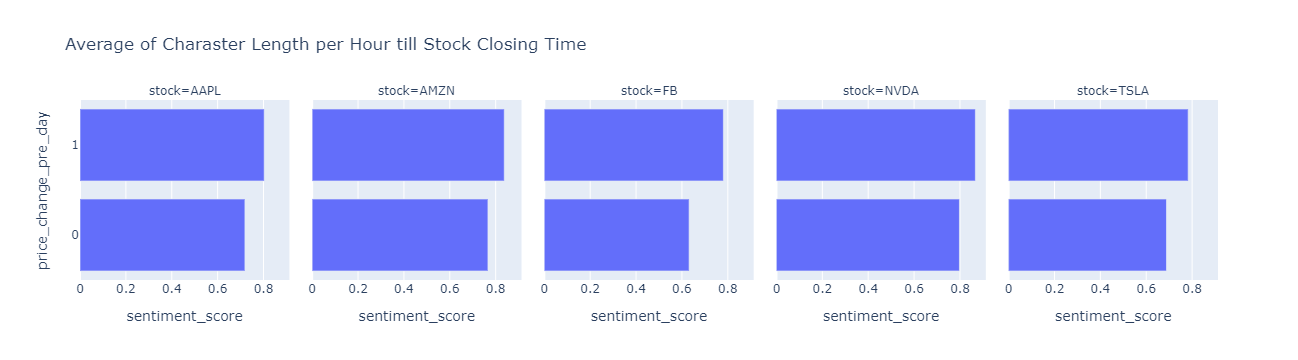

In [85]:
eda_by_group_3(df_twits_combined_with_feature_with_time_with_stock_new)

## Dimensionality Reduction

### hourly aggregation 

In [127]:
# group by features and average the sentiment score
class dimension_reduction:
    
    @classmethod
    def aggregate_by_features(cls, df: pd.DataFrame, groupby_list: list) -> pd.DataFrame:
        df_grouper = df.groupby(groupby_list)
        df_agg = df_grouper.mean().add_prefix('avg_')
        df_agg['count_record'] = df_grouper['hours_till_close'].count()
        df_agg.reset_index(inplace=True)
        df_agg.convert_dtypes()
        return df_agg

In [128]:
# groupby_list is the list for either the features or the target variables to be aggregated by
groupby_list = ['stock', 'created_date_local', 'created_month_local', 'created_day_local', 'created_weekday_local', 'created_hour_local', 
                'within_trading_time', 'hours_till_close','trading_date', 'price_change_same_day', 'price_change_pre_day']
df_all_grouped = dimension_reduction.aggregate_by_features(df_twits_combined_with_feature_with_time_with_stock_new, groupby_list)

In [129]:
df_all_grouped.groupby(['stock','hours_till_close']).count()

created_date_local  created_month_local  \
stock hours_till_close                                            
AAPL  0                                564                  564   
      1                                561                  561   
      2                                560                  560   
      3                                564                  564   
      4                                569                  569   
...                                    ...                  ...   
TSLA  91                                17                   17   
      92                                17                   17   
      93                                17                   17   
      94                                17                   17   
      95                                17                   17   

                        created_day_local  created_weekday_local  \
stock hours_till_close                                             
AAPL  0                               564                    564   
      1                               561                    561   
      2                               560                    560   
      3                               564                    564   
      4                               569                    569   
...                                   ...                    ...   
TSLA  91                               17                     17   
      92                               17                     17   
      93                               17                     17   
      94                               17                     17   
      95                               17                     17   

                        created_hour_local  within_trading_time  trading_date  \
stock hours_till_close                                                          
AAPL  0                                564                  564           564   
      1                                561                  561           561   
      2                                560                  560           560   
      3                                564                  564           564   
      4                                569                  569           569   
...                                    ...                  ...           ...   
TSLA  91                                17                   17            17   
      92                                17                   17            17   
      93                                17                   17            17   
      94                                17                   17            17   
      95                                17                   17            17   

                        price_change_same_day  price_change_pre_day  \
stock hours_till_close                                                
AAPL  0                                   564                   564   
      1                                   561                   561   
      2                                   560                   560   
      3                                   564                   564   
      4                                   569                   569   
...                                       ...                   ...   
TSLA  91                                   17                    17   
      92                                   17                    17   
      93                                   17                    17   
      94                                   17                    17   
      95                                   17                    17   

                        avg_count_like  avg_count_reshare  \
stock hours_till_close                                      
AAPL  0                            564                564   
      1                            561                561   
      2                            560       

In [31]:
# output file for correlation analysis
df_all_grouped.to_csv(r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\df_all_grouped.csv', index=False)

#### daily aggregation

In [126]:
df_twits_combined_with_feature_with_time_with_stock_new.head()

,created_at_utc,stock,count_like,count_reshare,sentiment_score,body_prepared,body_processed,count_mention,count_hashtag,count_cashtag,count_emoji,count_alpha,count_digit,count_all_char,count_token,count_sent,created_month_local,created_day_local,created_weekday_local,created_hour_local,within_trading_time,hours_till_close,trading_date,price_change_same_day,price_change_pre_day,created_date_local,pre_day_volume_zscore,sentiment_score_predicted,sentiment_score_combined
0,2020-01-01 05:06:58+00:00,AAPL,2,0,1,$AAPL good things happening 2020 run trump and everything’s gonna run up get it while you can follow the trend,cashtag_AAPL good things happening 2020 run trump and everything’s gonna run up get it while you can follow the trend,0,0,1,0,81,4,86,19,1,1,1,3,0,False,39,2020-01-02,0,1,2020-01-01,-0.332439,<NA>,1
1,2020-01-01 05:08:28+00:00,AAPL,3,0,1,$AAPL Happy New Year amazing winning AAPL Bulls! You’re making life fun and exciting!,cashtag_AAPL Happy New Year amazing winning AAPL Bulls! You’re making life fun and exciting!,0,0,1,0,64,0,67,13,2,1,1,3,0,False,39,2020-01-02,0,1,2020-01-01,-0.332439,<NA>,1
2,2020-01-01 05:14:51+00:00,AAPL,21,0,1,Happy New Year :) $AAPL $TSLA $AMZN $SPY $BTC.X,Happy New Year :) cashtag_AAPL cashtag_TSLA cashtag_AMZN cashtag_SPY cashtag_BTC.X,0,0,5,0,13,0,16,5,1,1,1,3,0,False,39,2020-01-02,0,1,2020-01-01,-0.332439,<NA>,1
3,2020-01-01 05:19:59+00:00,AAPL,1,0,<NA>,@Taxes_R2_Damn_High my dad ended this year by selling half his $aapl and $MSFT Two decades in almost exactly. I think no one is being careful. These parabolic moves can be dangerous. I know everyone is cheerful now!,mention_Taxes_R2_Damn_High my dad ended this year by selling half his cashtag_aapl and cashtag_MSFT Two decades in almost exactly. I think no one is being careful. These parabolic moves can be dangerous. I know everyone is cheerful now!,1,0,2,0,146,0,150,34,4,1,1,3,0,False,39,2020-01-02,0,1,2020-01-01,-0.332439,1,1
4,2020-01-01 05:37:42+00:00,AAPL,1,0,1,"$AAPL And to those using the tired and old delapidated PE ratio argument, I'll just leave you with this, oh, ours? Just 24.7 PE, at end of 2019 (with a massively more room to grow ).... Compare Apples' PE to other megacaps=, quote from article with a false negative title to begin with = ""Compared with the other megacap tech stocks, Apple's P/E ratio still ranks among the lowest. Amazon is finishing the year with a P/E of 81.8, Facebook's is 32.8, Microsoft's is 29.7, and Google-parent Alphabet's is 28.7."" !!!HAPPY NEW YEAR EVERYBODY!!! After its strongest year in a decade, Apple stock is historically expensive on a price-to-earnings basis -","cashtag_AAPL And to those using the tired and old delapidated PE ratio argument, I'll just leave you with this, oh, ours? Just 24.7 PE, at end of 2019 (with a massively more room to grow ).... Compare Apples' PE to other megacaps=, quote from article with a false negative title to begin with = ""Compared with the other megacap tech stocks, Apple's P/E ratio still ranks among the lowest. Amazon is finishing the year with a P/E of 81.8, Facebook's is 32.8, Microsoft's is 29.7, and Google-parent Alphabet's is 28.7."" !!!HAPPY NEW YEAR EVERYBODY!!! After its strongest year in a decade, Apple stock is historically expensive on a price-to-earnings basis -",0,0,1,0,468,19,533,110,7,1,1,3,0,False,39,2020-01-02,0,1,2020-01-01,-0.332439,<NA>,1


In [135]:
# groupby_list is the list for either the features or the target variables to be aggregated by daily target variable
groupby_list_daily = ['stock', 'within_trading_time', 'trading_date', 'price_change_same_day', 'price_change_pre_day']
df_all_grouped_daily = dimension_reduction.aggregate_by_features(df_twits_combined_with_feature_with_time_with_stock_new, groupby_list_daily)
df_all_grouped_daily.drop(columns=['avg_created_month_local', 'avg_created_day_local', 'avg_created_weekday_local', 'avg_created_hour_local'], inplace=True)

In [136]:
df_all_grouped_daily

,stock,within_trading_time,trading_date,price_change_same_day,price_change_pre_day,avg_count_like,avg_count_reshare,avg_sentiment_score,avg_count_mention,avg_count_hashtag,avg_count_cashtag,avg_count_emoji,avg_count_alpha,avg_count_digit,avg_count_all_char,avg_count_token,avg_count_sent,avg_hours_till_close,avg_pre_day_volume_zscore,avg_sentiment_score_predicted,avg_sentiment_score_combined,count_record
0,AAPL,False,2020-01-02,0,1,2.944690,0.066372,0.845745,0.121681,0.055310,2.026549,0.303097,95.464602,3.588496,104.975664,23.369469,2.000000,17.491150,-0.332439,0.727273,0.776549,452
1,AAPL,False,2020-01-03,0,0,2.072884,0.048589,0.673913,0.063480,0.042320,1.797022,0.394984,76.984326,2.634796,84.173981,18.911442,1.835423,15.686520,0.239195,0.570796,0.619122,1276
2,AAPL,False,2020-01-06,1,1,2.231039,0.064177,0.615152,0.056009,0.166861,2.149358,0.586931,91.822637,2.197200,99.466744,21.988331,1.926488,35.352392,0.417939,0.626186,0.621937,857
3,AAPL,False,2020-01-07,0,0,1.943953,0.044248,0.736842,0.070796,0.209440,2.153392,0.309735,86.802360,3.129794,95.020649,21.091445,1.781711,14.654867,-0.042596,0.776699,0.761062,339
4,AAPL,False,2020-01-08,1,1,2.166667,0.075221,0.62116,0.058997,0.042773,1.912979,0.535398,69.679941,1.781711,75.433628,16.952802,1.648968,17.182891,-0.199460,0.509091,0.557522,678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5453,TSLA,True,2022-02-22,0,0,1.613290,0.023965,0.637037,0.024510,0.016340,1.403595,0.377451,49.852941,1.801743,54.832244,12.405229,1.504357,2.780501,-0.704964,0.478114,0.559913,1836
5454,TSLA,True,2022-02-23,0,0,1.284633,0.022047,0.499375,0.028628,0.017769,1.338927,0.292201,48.599210,1.686081,53.088516,12.066798,1.500494,2.704837,-0.571148,0.402363,0.453439,3039
5455,TSLA,True,2022-02-24,1,1,1.363794,0.016890,0.750809,0.025552,0.015158,1.391945,0.483759,47.174534,1.363794,51.473365,11.554786,1.498051,2.864010,-0.462831,0.578751,0.670853,2309
5456,TSLA,True,2022-02-25,1,1,1.420875,0.015488,0.793149,0.026936,0.016162,1.454545,0.470034,48.960269,1.671380,53.667340,12.033670,1.501010,3.241751,-0.100242,0.625344,0.711111,1485


In [137]:
# output file for correlation analysis
df_all_grouped_daily.to_csv(r'C:\Users\frank\OneDrive\Documents\Learning\NUS MTech EBCA\3. Course Material\EBA5004 PLP\4. Practice Module Project\data\Processed\StockTwits\Combined\df_all_grouped_daily.csv', index=False)